In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns 
import imageio                      # for creating GIF images 
import pandas as pd 

from mobility_model import *        # Load the Gauss-Markov mobility model 
from channel_model import *         # Load the channel model (LoS+NLoS)
from traffic_model import *         # Load the traffic model 
from uav_controller import *        # Load the UAV movement controller class 
from utils import * 

rng = np.random.default_rng()

%matplotlib inline

tensorflow version: 2.6.0
keras version: 2.6.0


# Simulation parameters

### System parameters
Expoential Moving Average (EMA): $$s(t) = \alpha \times x(t) + (1-\alpha) \times s(t-1)$$
The time constant ($\tau$) of an EMA is the amount of time for the smoothed response of a unit step function to reach $1-1/e=63.2\%$ of the original signal. The relation between the time constatn ($\tau$), the smoothing factor ($\alpha$), and the time slot ($\Delta_t$) is: $$\alpha = \frac{\Delta_t}{\tau}$$

Reference: [Wikipedia](https://en.wikipedia.org/wiki/Exponential_smoothing)

Another interpretation: For a $x$-day moving average, the smoothing factor should be $\alpha=\frac{2}{x+1}$. Reference: [here](https://www.investopedia.com/terms/m/movingaverage.asp).

In [2]:
'''System parameters''' 

n_users =  25                           # number of users 
n_slots = 1 + np.int32(1.0e3)           # no. of slots in total 
slot_len = 1                            # one second, fixed 

# Expoential Moving Average (EMA): s(t) = alpha*x(t) + (1-alpha)*s(t-1) 
alpha_ema = 0.4                         # the smoothing factor of EMA 

### UAV-User Communications

In [3]:
'''Parameters for communications'''

ref_receive_pw = dB(-40)                # reference received signal strength at 1 meter        
bw_1user = MHz(2)                       # bandwidth for one user  
channel_bandwidth = bw_1user*n_users    # total bandwith for all users, reference: 12 MHz for 5 users  
pTx_downlink = mW(200)                  # transmit power (fixed) in mW of the UAV
noise_pw_total = dBm(-90)               # total noise power 


### User Mobility

In [4]:
'''Parameters for the mobility model for users'''

boundary = 250              # reference: 250 m with 5 users  

initial_distance_range_x = range(-boundary, boundary+1, 10)
initial_distance_range_y = range(-boundary, boundary+1, 10)

hot_spot_range = 0 
upper_left = (-boundary,boundary)
lower_right = (-(boundary-hot_spot_range), boundary-hot_spot_range)


### User Traffic

In [5]:
'''Parameters for the data traffic model'''

ON_data_arrival_mean_Mb = [0.3, 1.0]    # in Mb, Reference: 1.2 Mbps for 12 MHz with 5 users 
ON_duration_mean_tslot = 60             # in # of time slots 
OFF_duration_mean_tslot = 60            # in # of time slots 

requesting_rate = ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot)   # Rate (on average) at which users sending a download request
traffic_mean_Mb = np.mean(ON_data_arrival_mean_Mb)*requesting_rate                          # Average traffic load if a user sending a request 

# Normalizaiton coefficients 
queue_norm_Mb = ON_duration_mean_tslot*np.max(ON_data_arrival_mean_Mb)          # in Mb 
traffic_norm_Mb = 3*np.max(ON_data_arrival_mean_Mb)        # in Mb 
ch_capacity_norm_Mb = 3*np.max(ON_data_arrival_mean_Mb)    # in Mb 
normalization_coeff = (queue_norm_Mb, traffic_norm_Mb, ch_capacity_norm_Mb)

print(f'Requesting rate: {requesting_rate} \t\t# Rate (on average) at which users sending a download request')
print(f'Arrival traffic: {traffic_mean_Mb} Mbps \t# Average traffic load (of all services) if a user sending a request')
print(f'\nNormalization coefficients: \nqueue_len_norm: \t{queue_norm_Mb} Mb \ntraffic_arr_norm: \t{traffic_norm_Mb} Mb \nch_capacity_norm: \t{ch_capacity_norm_Mb} Mb')


Requesting rate: 0.5 		# Rate (on average) at which users sending a download request
Arrival traffic: 0.325 Mbps 	# Average traffic load (of all services) if a user sending a request

Normalization coefficients: 
queue_len_norm: 	60.0 Mb 
traffic_arr_norm: 	3.0 Mb 
ch_capacity_norm: 	3.0 Mb


### Optimization parameters

In [6]:
'''Parameters for the UAV movement controller''' 

uav_altitude = 50                       # altitude of the uav in meter, fixed 
uav_speed_max = 5                      # in meter/second (m/s)

n_grids = 25 
grid_size = int(2*boundary/n_grids)     # IMPORTANT: expected shape of the DNN input: 25x25 
n_decisions = 20 
lyapunov_param = 1                      # parameter V in the Lyapunov framework

print(f'Coverage area (m): \t{boundary} x {boundary}')
print(f'Grid size (m): \t\t{grid_size} x {grid_size}')
print(f'Heat map image: \t{n_grids} x {n_grids}')


Coverage area (m): 	250 x 250
Grid size (m): 		20 x 20
Heat map image: 	25 x 25


# Initialization

### Initialize Users and UAVs (ABSs)

In [7]:
class User:
    def __init__(self, name) -> None:
        self.name=name
        self.x = None               # x-axis
        self.y = None               # y-axis 


In [8]:
class MEC_Server:
    def __init__(self, name, uav_altitude=50, speed_max=0):
        self.name = name 
        
        self.x = np.zeros(shape=(n_slots)) 
        self.y = np.zeros(shape=(n_slots)) 
        self.altitude = uav_altitude
        self.speed_max = speed_max                                          # in meter/second 
        
        self.chgains_downlink = np.zeros(shape=(n_users, n_slots))          # real number, non negative
        self.alpha = np.zeros(shape=(n_users, n_slots))                     # bandwidth allocation, in range(0,1)
        self.channel_capacity_Mb = np.zeros(shape=(n_users, n_slots))       
        self.queue_length_Mb = np.zeros(shape=(n_users, n_slots))
        self.downlink_throughput_Mb = np.zeros(shape=(n_users, n_slots))
        
        self.arrival_traffic_Mb = np.zeros(shape=(n_users, n_slots))
        self.traffic_state = np.zeros(shape=(n_users, n_slots))
        self.active_state = np.zeros(shape=(n_users, n_slots)) 
        self.traffic_type = np.zeros(shape=(n_users, n_slots)) 
        
        self.mos = np.zeros(shape=(n_users, n_slots))             # Mean Opinion Score (MOS)
        self.ema_qlen_Mb = np.zeros(shape=(n_users, n_slots))     # Exponential Moving Average (EMA) of the queue length 
        self.ema_drate_Mbps = np.zeros(shape=(n_users, n_slots))  # EMA of the data rate (arrival traffic)    


In [9]:
users = [User(f'user[{i}]') for i in range(n_users)]

print(f'Initialized {n_users} users')

Initialized 25 users


In [10]:
uav_fixed = MEC_Server(name='uav (fixed at O)', uav_altitude=uav_altitude, speed_max=0)
uav_centroid = MEC_Server(name='uav (centroid of all users)', uav_altitude=uav_altitude, speed_max=uav_speed_max)
uav_centroid_active = MEC_Server(name='uav (centroid of active users)', uav_altitude=uav_altitude, speed_max=uav_speed_max)
uav_proposed = MEC_Server(name='uav (proposed)', uav_altitude=uav_altitude, speed_max=uav_speed_max)

servers = [uav_fixed, uav_centroid, uav_centroid_active, uav_proposed]  # do not consider uav_centroid_active

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'] # colors used for UAVs 

print(f'Initialized {len(servers)} UAVs:')
for id, server in enumerate(servers):
    print(f'({id}) {server.name}')
    

Initialized 4 UAVs:
(0) uav (fixed at O)
(1) uav (centroid of all users)
(2) uav (centroid of active users)
(3) uav (proposed)


### User Movement (Gauss-Markov Model)

In [11]:
""" User movement: Gauss-Markov mobility model """
for user_idx, user in enumerate(users):
    x0 = rng.choice(initial_distance_range_x)
    y0 = rng.choice(initial_distance_range_y)
    user.x, user.y = generate_mobility_GM(x0=x0, y0=y0, boundary=boundary, 
                                          n_slots=n_slots, slot_len=slot_len, 
                                          upper_left=upper_left, lower_right=lower_right)
        
    
# Calculate the center of all users over time 
x_centroid, y_centroid = np.zeros(shape=(n_slots)), np.zeros(shape=(n_slots))
for user in users: 
    x_centroid += user.x 
    y_centroid += user.y 
x_centroid /= n_users
y_centroid /= n_users


print('Generated user movements')


Generated user movements


#### Create an animation (a gif image) of user locations over time
Clide [here](https://towardsdatascience.com/how-to-create-a-gif-from-matplotlib-plots-in-python-6bec6c0c952c) for a reference on Towards Data Science on how to create animations in Python. 

In [12]:
# t_max = n_slots
# t_step = 10    
# marker_sz = 2 

# def create_image_of_user_locations(t, folder_name):
    
#     plt.figure(figsize=(5,5))    # figsize in inch 

#     # Plot the boundary 
#     radius = boundary  # in meter
#     plt.plot(-radius, radius, 'sw', markersize=1)
#     plt.plot(-radius, -radius, 'sw', markersize=1)
#     plt.plot(radius, radius, 'sw', markersize=1)
#     plt.plot(radius, -radius, 'sw', markersize=1)
    
#     ### Plot users' location
#     server = uav_proposed
#     for user_idx, user in enumerate(users):
#         plt.plot(user.x[t], user.y[t], linestyle='None', marker='.', color='k', markersize=marker_sz)
#     plt.plot(user.x[t], user.y[t], linestyle='None', marker='+', color='k', markersize=marker_sz, label='mobile users')

#     plt.xlim(-270, 270)
#     plt.ylim(-270, 270)
#     plt.xticks(np.arange(-250, 251, step=100))
#     plt.yticks(np.arange(-250, 251, step=100))
#     plt.legend(loc='upper right')       # options: 'best', 'upper left', 'upper right', 'lower left', 'lower right'
#     plt.grid(True)
    
#     plt.title(f'time = {t} (second)')
#     plt.xlabel('x (m)')
#     plt.ylabel('y (m)')
    
#     plt.savefig(os.path.join(os.getcwd(), folder_name, f"t{t}.png"), bbox_inches='tight', dpi=600)
#     plt.close()
  
  
# # plot user locations in each time slot as png images  
# folder_name = 'png2gif'
# for t in range(0,t_max,t_step): 
#     create_image_of_user_locations(t, folder_name) 


# # save all image into a list 
# images = []
# for t in range(0,t_max,t_step): 
#     image = imageio.v2.imread(os.path.join(os.getcwd(), folder_name, f"t{t}.png"))
#     images.append(image)
    
    
# # combine all images into a GIF 
# imageio.mimsave(os.path.join(os.getcwd(), folder_name, 'user_location.gif'),
#                 ims = images,       # list of input images 
#                 fps = 1)            # optional, frames per second 

#### Plot real-time locations of users

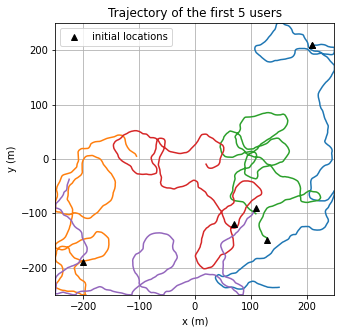

In [13]:
""" Plot real-time locations """ 
plt.figure(figsize=(5,5))    # figsize in inch 

## Plot users' location
for user_idx, user in enumerate(users[:5]):
    # plt.plot(user.x, user.y, label=user.name)
    plt.plot(user.x, user.y)
    plt.plot(user.x[0], user.y[0], '^k')
plt.plot(users[0].x[0], users[0].y[0], '^k', label=f"initial locations")

# ### Plot the centroid of users' location 
# plt.plot(x_centroid, y_centroid, 'b', label='centroid of all users')
# plt.plot(x_centroid[0], y_centroid[0], '^k')

# Plot the centroid of active users' location 
# plt.plot(x_centroid_active, y_centroid_active, '-b', label='centroid of active users')
# plt.plot(x_centroid_active[0], y_centroid_active[0], '^k')

# Plot the UAV movement (following centroids of active users)
# server = uav_centroid_active
# plt.plot(server.x, server.y, 'k', label=server.name)
# plt.plot(server.x[0], server.y[0], '*k', markersize=12)

# # Plot the UAV movement (proposed)
# server = uav_proposed
# plt.plot(server.x, server.y, 'r', label=server.name)
# plt.plot(server.x[0], server.y[0], '*r', markersize=12)

plt.legend()
plt.grid(True)

plt.xlim([-boundary, boundary])
plt.ylim([-boundary, boundary])

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trajectory of the first 5 users')

plt.show()
# plt.savefig(os.path.join(os.getcwd(), "mobility_model.jpg"))

### User Downlink Traffic

##### The ON-OFF Model
Reference on the Exponential Moving Average (EMA): [here]()

In [14]:
from copy import deepcopy

arrival_traffic_Mb = np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)
ema_traffic_Mb =  np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)        # EMA of the arrival rate (Mbps)
traffic_state = np.full(shape=(n_users, n_slots), fill_value=0, dtype=bool)
traffic_type = np.full(shape=(n_users,n_slots), fill_value=-1, dtype=int)

for user_idx, user in enumerate(users): 
    traffic_state[user_idx,:], arrival_traffic_Mb[user_idx,:], traffic_type[user_idx,:] = \
        generate_traffic_ON_OFF(n_slots=n_slots, 
                                ON_duration_mean_tslot = ON_duration_mean_tslot,
                                OFF_duration_mean_tslot = OFF_duration_mean_tslot,
                                data_arrival_mean_Mb = ON_data_arrival_mean_Mb)

ema_traffic_Mb[:, 0] = alpha_ema*arrival_traffic_Mb[:,0]
for t in range(1,n_slots): 
    ema_traffic_Mb[:, t] = alpha_ema*arrival_traffic_Mb[:,t] + (1-alpha_ema)*ema_traffic_Mb[:,t-1]


for server in servers: 
    server.arrival_traffic_Mb = deepcopy(arrival_traffic_Mb)
    server.traffic_state = deepcopy(traffic_state)
    server.traffic_type = deepcopy(traffic_type)
    server.ema_drate_Mbps = deepcopy(ema_traffic_Mb)


print('Generated arrival traffic for each user\n')
print('Mean Traffic of one user (expected): \t{x:.2f} Mb/slot'.format(x=np.mean(ON_data_arrival_mean_Mb)*ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot)) )
print('Mean Traffic of one user (generated): \t{x:.2f} Mb/slot'.format(x=np.mean(arrival_traffic_Mb)) )
print('Arrival Rate in ON-state (generated): \t{x:.2f} Mb/slot'.format(x=np.sum(arrival_traffic_Mb)/np.sum(traffic_state)))


Generated arrival traffic for each user

Mean Traffic of one user (expected): 	0.33 Mb/slot
Mean Traffic of one user (generated): 	0.33 Mb/slot
Arrival Rate in ON-state (generated): 	0.64 Mb/slot


##### Plot the downlink traffic

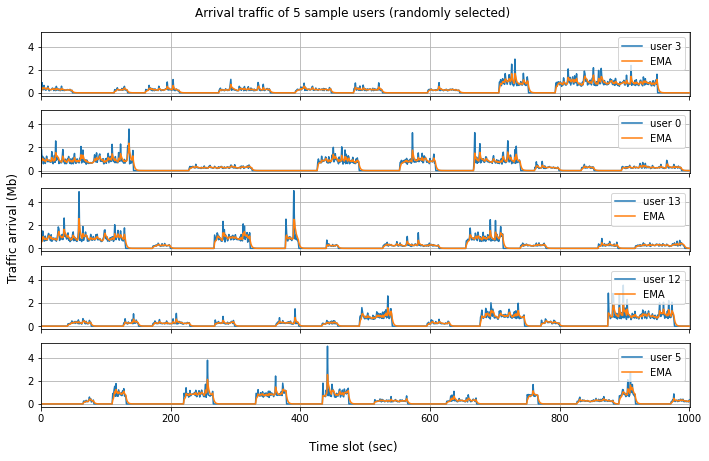

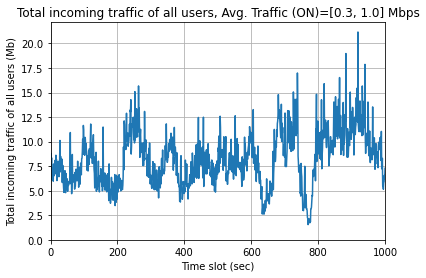

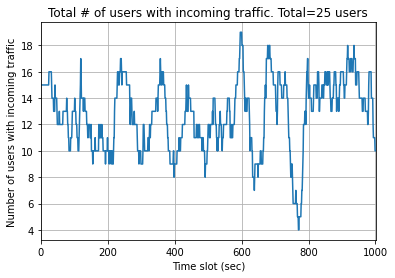

In [15]:
'''Plot arrival traffic of some sample users''' 
n_samples = 5 
sample_ids = np.random.choice(n_users, size=(n_samples), replace=False) # randomly select some users for plotting 

fig, axes = plt.subplots(n_samples,1, figsize=(10, 6.4), sharex=True, sharey=True)

for i, axis in enumerate(axes): 
    
    axis.plot(arrival_traffic_Mb[sample_ids[i]], label=f'user {sample_ids[i]}')
    axis.plot(ema_traffic_Mb[sample_ids[i]], label='EMA')
    
    axis.grid(True)
    axis.legend(loc='upper right')

    axis.set_xlim([0, n_slots])
    
fig.suptitle(f"Arrival traffic of {n_samples} sample users (randomly selected)")
fig.supxlabel('Time slot (sec)')
fig.supylabel('Traffic arrival (Mb)')

fig.tight_layout()

plt.savefig("incoming_traffic_of_sample_users_over_time.png", dpi=600, bbox_inches='tight')
# plt.show()


"""Total incoming traffic of all users """
traffic_sum_Mb = np.sum(arrival_traffic_Mb, axis=0)

plt.figure() 

plt.plot(traffic_sum_Mb)
plt.grid(True)

plt.xlabel('Time slot (sec)')
plt.ylabel('Total incoming traffic of all users (Mb)')
plt.title(f'Total incoming traffic of all users, Avg. Traffic (ON)={ON_data_arrival_mean_Mb} Mbps')

plt.xlim([0, n_slots])
plt.ylim(bottom=0)
fig.tight_layout()

plt.show()


'''Number of users with incoming traffic''' 
traffic_state_sum = np.sum(traffic_state, axis=0)

plt.figure() 

plt.plot(traffic_state_sum)
plt.grid(True)

plt.xlabel('Time slot (sec)')
plt.ylabel('Number of users with incoming traffic')
plt.title(f'Total # of users with incoming traffic. Total={n_users} users')

plt.xlim([0, n_slots])
fig.tight_layout()

plt.show()


# The system evolves over time
- The UAVs and users move round within the target zone 
- Channel condition fluctuation due to user movement
- Queue evolves based on arrival traffic and channel throughput


### Utility Functions
- Calcualte real-time __channel fadding gain__, given locations of the user and the UAV
- Calcualte __bandwidth allocation__ for each user (*) 
- Calculate real-time __channel capacity__ (maximum comm. rate) of each user 
- Find __active users__ in a time slot
- Calculate __effective throughput__ of each user 
- Update __queue length__ of each user 

(*) NOTE 2023/04/19: all users allocated fixed bandwidth, alpha = 1 for all users 

In [16]:
def cal_channel_fading_gain(x_user, y_user, x_uav, y_uav, uav_altitude): 
    '''
    Calculate the channel fading gain from locations of the user and the UAV
    Arguments: 
        (x_user, y_user) : location of user A at time t 
        (x_uav, y_uav, uav_altitude) : location of the UAV at time t 
    Return: 
        channel_gain : the channel gain of the UAV - user A link at time t 
    '''
    radius_distance = np.sqrt(x_user**2 + y_user**2)    
    propagation_distance = np.sqrt((x_user-x_uav)**2 + (y_user-y_uav)**2 + uav_altitude**2)   
    elev_angle_deg = rad2deg(np.arctan(uav_altitude/radius_distance))
    channel_gain = channel_fading_gain_mean(elev_angle_deg) \
            * ref_receive_pw / propagation_distance**path_loss_exponent(elev_angle_deg)
    return channel_gain


def cal_channel_capacity_Mb(channel_gain, alpha): 
    ''' 
    Calculate the bandwidth (channel capacity, in Mbps) of one user in a time slot 
    Arguments:
        channel_gain: channel gain of the UAV-user link at time t 
        alpha : the bandwidth allocated to the user A at time t, alpha in range (0,1)
    Return: 
        capacity (Mb) : the channel capacity of the UAV-user link at time t 

    NOTE 2023/04/19: bandwidth of one users are fixed, alpha should be equal to 1 for all users 
    '''
    assert alpha == 1, "alpha shoule equal to 1 for all users"
    SNR = pTx_downlink * channel_gain / noise_pw_total
    capacity_Mb = to_Mbit(alpha * bw_1user * np.log2(1 + SNR) * slot_len )
    return capacity_Mb 


def find_active_users(queue_len_Mb=0, incoming_traffic_Mb=0): 
    ''' 
    Find active users (queue length > 0 or incoming traffic > 0)
    Parameters: 
        - queue_len_Mb (shape=(n_users,)): current queue length in Mb
        - incoming_traffic_Mb (shape=(n_users,)): new traffic in Mb 
    Returns:
        - active_state (shape=(n_users,)): binary (0-inactive or 1-active) 
    '''
    traffic_total_Mb  = queue_len_Mb + incoming_traffic_Mb      # shape = (n_users,)
    active_state =  np.array(traffic_total_Mb > 0)              # shape = (n_users,)
    return active_state


def cal_bandwidth_equal(active_state):
    '''
    Equal bandwidth allocation for each active user. 
    Example: 5 out of 10 users are active -> allocate 1/5 of the total bandwidth to each
    
    Parameters:  
        - active_state: shape = (n_users,), =1 if queue + traffic_arrival > 0
    Returns: 
        - alpha: bandwidth allocation, in range (0,1), shape=(n_users,)
    
    NOTE 2023/04/19: alpha = 1 for all users, since users are allocated fixed bandwidth during the process  
    '''
    # alpha = np.ones(shape=(n_users)) * 1/n_users              # shape = (n_users,), equally shared between all users  
    # alpha = active_state*1/np.sum(active_state) + 1e-6        # shape = (n_users,), equally shared between active users 
    alpha = np.ones(shape=(n_users))
    return alpha 


def update_queue_Mb(qlen_prev_Mb, arrival_Mb, departure_Mb):
    '''Return qlen in the next time slot based on qlen in the previous tslot, arrival, and departure'''
    qlen_next_Mb = np.max([qlen_prev_Mb + arrival_Mb - departure_Mb, 0])
    return qlen_next_Mb


def cal_downlink_throughput_Mb(qlen_prev_Mb, arrival_Mb, channel_capacity_Mb):
    throughput_Mb = np.min([channel_capacity_Mb, qlen_prev_Mb + arrival_Mb])
    return throughput_Mb



### Estimation of QoE Score (MOS) 
 

In [17]:
def mos_func(qlen, lambda_): 
    ''' Estimate the Mean Opinion Score (MOS) of users, 
        given the current queue length and the expected arrival rate  
        
        Parameters: 
            - qlen: scalar or array-like 
            - lambda_: scalar or array-like
        Return: 
            - mos_val: scalar or array-like 
            
        Reference: ITU-T G.1030 (02/2014), eq. (II-2) and Fig. II.4, page 17
    '''
    a, b = 5.72, 0.936
    mos_val_min, mos_val_max = 1.0, 5.0 
    mos_val = a - b*np.log(qlen/lambda_ + 1e-6)
    mos_val = np.minimum(mos_val, mos_val_max)      
    mos_val = np.maximum(mos_val, mos_val_min)
    
    return mos_val 

   qlen_Mb  arrival_rate_Mbps       mos
0        0                1.0  5.000000
1        1                1.0  5.000000
2        2                1.0  5.000000
3        3                1.0  4.691699
4        4                1.0  4.422428


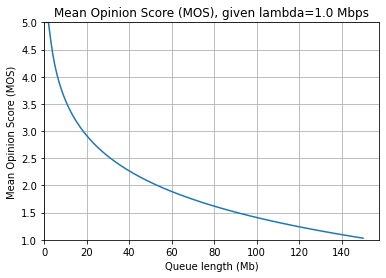

In [18]:
'''Visualize the MOS function'''

qlen = np.arange(0, 151, step=1)                # Mb 
lambda_ = np.ones(shape=(len(qlen)))            # Mbps 

mos = mos_func(qlen=qlen, lambda_=lambda_)

df_mos = pd.DataFrame({
    'qlen_Mb': qlen,
    'arrival_rate_Mbps': lambda_,    
    'mos': mos
})

print(df_mos.head())

sns.lineplot(data=df_mos, x='qlen_Mb', y='mos')

plt.grid(True)
plt.xlim(left=0)
plt.ylim([1,5])

plt.xlabel('Queue length (Mb)')
plt.ylabel('Mean Opinion Score (MOS)')
plt.title(f'Mean Opinion Score (MOS), given lambda={lambda_[0]} Mbps')

plt.show()

### Evolvement of the system
Each UAV adjust its location over time corresponding to user's movement. <br>
Note: *Only UAVs in the list `servers` are considered.* 

In [19]:
"""UAV 1 (fixed at O)""" 
### The UAV: fixed at (0,0)
uav_fixed.x[:] = 0
uav_fixed.y[:] = 0


"""UAV 2 (centroid of all users) movement""" 
### The UAV starts at the centre then follows the centroid with fixed speed 
uav_centroid.x[0], uav_centroid.y[0] = (0, 0)
for t in range(1,n_slots): 
    dx, dy, dd = cal_direction(uav_centroid.x[t-1], uav_centroid.y[t-1], x_centroid[t], y_centroid[t])
    uav_speed = np.min([dd/(uav_centroid.speed_max*slot_len), 1])*uav_centroid.speed_max
    uav_centroid.x[t], uav_centroid.y[t] = update_UAV_location(x0=uav_centroid.x[t-1], y0=uav_centroid.y[t-1],
                                                               dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)


"""UAV 3 (centroid of active users) movement"""
# Note: movement of UAV 3 will be calculated LATER in a slot-by-slot manner according to the user state (active/inactive)
uav_centroid_active.x[0], uav_centroid_active.y[0] = (0,0)


'''UAV 4 (Proposed) movement'''
# Note: movement of UAV 4 will be updated LATER in a slot-by-slot manner according to user statistics,
# i.e., whether the user is active and how large the queue+new traffic is 
uav_controller = UAV_Movement_Controller(boundary=boundary, grid_size=grid_size, 
                                     uav_speed_max=uav_speed_max, n_decisions=n_decisions)    
uav_proposed.x[0], uav_proposed.y[0] = (0,0)
uav_controller.cal_channel_fading_gain = cal_channel_fading_gain 
uav_controller.cal_channel_capacity_Mb = cal_channel_capacity_Mb
uav_controller.uav_altitude = uav_proposed.altitude
uav_controller.Vlya = lyapunov_param


""" Evolvement of the MEC system """
x_centroid_active, y_centroid_active = np.zeros(shape=(n_slots)), np.zeros(shape=(n_slots))
for t in range(0, n_slots):      # t = timeslot
    x_user = np.array( [user.x[t] for user in users] )     # shape = (n_users,)
    y_user = np.array( [user.y[t] for user in users] )     # shape = (n_users,)

    for server in servers: 
        
        ### For every UAV: allocate channel bandwidth EQUALLY to all users 
        server.active_state[:,t] = find_active_users(queue_len_Mb=server.queue_length_Mb[:,t-1] if t>0 else 0, 
                                                     incoming_traffic_Mb=server.arrival_traffic_Mb[:,t])
        server.alpha[:,t] = cal_bandwidth_equal(active_state=server.active_state[:,t])  
        
        
        ### Movement of UAV 3 (following the centroid of active users)
        if server==uav_centroid_active and t>0:
            n_active_users = np.sum(server.active_state[:,t])   # shape = (n_users,)
            x_centroid_active[t] = np.sum(x_user*server.active_state[:,t])/n_active_users if n_active_users>0 else x_centroid_active[t-1]    # shape = (n_users,)
            y_centroid_active[t] = np.sum(y_user*server.active_state[:,t])/n_active_users if n_active_users>0 else y_centroid_active[t-1]    # shape = (n_users,)
            dx, dy, dd = cal_direction(server.x[t-1], server.y[t-1], x_centroid_active[t], y_centroid_active[t])
            uav_speed = np.min([dd/(server.speed_max*slot_len), 1])*server.speed_max
            server.x[t], server.y[t] = update_UAV_location(x0=server.x[t-1], y0=server.y[t-1],
                                                            dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
            
            
        ### Movement of UAV 4 (proposed)
        if server==uav_proposed and t>0: 
            # Extract the UAV location and generate heatmaps of all user statistics
            uav_location = (server.x[t-1], server.y[t-1])
            user_locations = (x_user, y_user)                       # x_user.shape = (n_users,)
            queue_Mb =  server.queue_length_Mb[:,t-1]               # shape = (n_users,)
            traffic_Mb = 1e-6 + server.arrival_traffic_Mb[:,t]      # shape = (n_users,)
            ch_capacity_Mb = server.channel_capacity_Mb[:,t-1]      # shape = (n_users,)
            user_statistics = (queue_Mb, traffic_Mb, ch_capacity_Mb)

            
            # (1) make a movement decision based on the UAV's current location and the heatmaps (i.e, calculate dx, dy, and uav_speed),
            # (2) update the replay memory, and  (3) retrain the DNN periodically 
            dnn_prediction, best_decision = uav_controller.make_movement_decision(uav_location=uav_location, 
                                                                    user_locations=user_locations,
                                                                    user_statistics=user_statistics,
                                                                    normalization_coeff=normalization_coeff)
            dx, dy, uav_speed = best_decision       # dx and dy in range (-1,1), uav_speed in range (0,uav_speed_max)
            
            # Update the UAV location 
            server.x[t], server.y[t] = update_UAV_location(x0=server.x[t-1], y0=server.y[t-1],
                                                            dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
            server.x[t] = adjust_location(server.x[t], bound=boundary)
            server.y[t] = adjust_location(server.y[t], bound=boundary)


        ### Evolution of the system 
        for i, user in enumerate(users):      # i = user ID 
            server.chgains_downlink[i,t] = cal_channel_fading_gain(user.x[t], user.y[t], server.x[t], server.y[t], server.altitude)  
            server.channel_capacity_Mb[i,t] = cal_channel_capacity_Mb(server.chgains_downlink[i,t],  server.alpha[i,t])
            qlen_prev_Mb = server.queue_length_Mb[i,t-1] if t > 0 else 0
            server.queue_length_Mb[i,t] = update_queue_Mb(qlen_prev_Mb=qlen_prev_Mb, 
                                                            arrival_Mb=server.arrival_traffic_Mb[i,t],
                                                            departure_Mb=server.channel_capacity_Mb[i,t])
            server.downlink_throughput_Mb[i,t] = cal_downlink_throughput_Mb(qlen_prev_Mb=qlen_prev_Mb, 
                                                                arrival_Mb=server.arrival_traffic_Mb[i,t],
                                                                channel_capacity_Mb=server.channel_capacity_Mb[i,t])  
            server.ema_qlen_Mb[i,t] = alpha_ema*server.queue_length_Mb[i,t] + (1-alpha_ema)*server.ema_qlen_Mb[i,t-1]
            
            # server.mos[i,t] = server.ema_qlen_Mb[i,t]/server.ema_drate_Mbps[i,t] if server.active_state[i,t]==True else np.NaN
            
            if server.active_state[i,t]==True: 
                # active user 
                server.mos[i,t] = mos_func(qlen=server.ema_qlen_Mb[i,t],
                                           lambda_= server.ema_drate_Mbps[i,t])
            else: # inactive user 
                server.mos[i,t] = np.nan 
            
print('Simulation finished.')


1/1 - 2s - loss: 0.4211 - mae: 0.5818 - val_loss: 0.4057 - val_mae: 0.5760
2/2 - 1s - loss: 0.4079 - mae: 0.5733 - val_loss: 0.4102 - val_mae: 0.5820
2/2 - 0s - loss: 0.4037 - mae: 0.5697 - val_loss: 0.4093 - val_mae: 0.5811
2/2 - 0s - loss: 0.4012 - mae: 0.5670 - val_loss: 0.4070 - val_mae: 0.5783
2/2 - 0s - loss: 0.4000 - mae: 0.5616 - val_loss: 0.4058 - val_mae: 0.5778
2/2 - 0s - loss: 0.3967 - mae: 0.5590 - val_loss: 0.4040 - val_mae: 0.5744
2/2 - 0s - loss: 0.3948 - mae: 0.5599 - val_loss: 0.4009 - val_mae: 0.5758
2/2 - 0s - loss: 0.3975 - mae: 0.5622 - val_loss: 0.4029 - val_mae: 0.5747
3/3 - 0s - loss: 0.4068 - mae: 0.5689 - val_loss: 0.4066 - val_mae: 0.5772
3/3 - 0s - loss: 0.4048 - mae: 0.5676 - val_loss: 0.3999 - val_mae: 0.5708
3/3 - 0s - loss: 0.4018 - mae: 0.5641 - val_loss: 0.4020 - val_mae: 0.5712
3/3 - 0s - loss: 0.3983 - mae: 0.5618 - val_loss: 0.3924 - val_mae: 0.5632
3/3 - 0s - loss: 0.3916 - mae: 0.5556 - val_loss: 0.3895 - val_mae: 0.5600
3/3 - 0s - loss: 0.3911 -

### Statistics of System's Performance


##### Movemenet of Users & UAVs


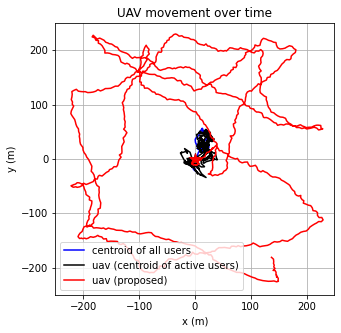

In [20]:
""" Plot real-time locations """ 

plt.figure(figsize=(5,5))    # figsize in inch 

### Plot users' location
# for user_idx, user in enumerate(users):
#     # plt.plot(user.x, user.y, label=user.name)
#     plt.plot(user.x, user.y)
#     plt.plot(user.x[0], user.y[0], '^k')
# plt.plot(users[0].x[0], users[0].y[0], '^k', label=f"initial location of users")

### Plot the centroid of users' location 
plt.plot(x_centroid, y_centroid, 'b', label='centroid of all users')
plt.plot(x_centroid[0], y_centroid[0], '^k')

### Plot the centroid of active users' location 
# plt.plot(x_centroid_active, y_centroid_active, '-r', label='centroid of active users')
# plt.plot(x_centroid_active[0], y_centroid_active[0], '^k')

### Plot the UAV movement (following centroids of active users)
if uav_centroid_active in servers: 
    server = uav_centroid_active
    plt.plot(server.x, server.y, 'k', label=server.name)
    plt.plot(server.x[0], server.y[0], '*k', markersize=12)

### Plot the UAV movement (proposed)
if uav_proposed in servers: 
    server = uav_proposed
    plt.plot(server.x, server.y, 'r', label=server.name)
    plt.plot(server.x[0], server.y[0], '*r', markersize=12)

plt.legend()
plt.grid(True)
plt.xlim([-boundary, boundary])
plt.ylim([-boundary, boundary])

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('UAV movement over time')

plt.show()
# plt.savefig(os.path.join(os.getcwd(), "mobility_model.jpg"))


##### Number of Active Users


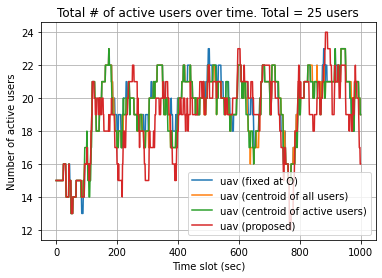

In [21]:
'''Number of active users over time (for each UAV)'''
plt.figure()

for server in servers: 
    plt.plot(np.sum(server.active_state, axis=0), label=server.name)

plt.legend()
plt.grid(True)

plt.xlabel('Time slot (sec)')
plt.ylabel('Number of active users')
plt.title(f'Total # of active users over time. Total = {n_users} users')

plt.show()


##### Channel Capacity & Downlink Throughput


In [22]:
""" Average channel capacity provided by each UAV """

# plt.figure(figsize=(12,6))

# for i, server in enumerate(servers):
#     rolling_interval = 1
#     kpi = export_moving_average(np.sum(server.channel_capacity_Mb, axis=0)/n_users, rolling_intv=rolling_interval) # avoid dividing by 0
#     plt.plot(kpi, label=f'{server.name}, AVG of all users', linestyle = '-', color=colors[i])      
    
#     kpi2 = export_moving_average(np.sum(server.channel_capacity_Mb*server.active_state, axis=0)/np.maximum(1, np.sum(server.active_state, axis=0)),
#                                 rolling_intv=rolling_interval) # avoid dividing by 0
#     plt.plot(kpi2, label=f'{server.name}, AVG of ACTIVE users', linestyle = '--', color=colors[i])

# traffic_incoming_avg = np.sum(arrival_traffic_Mb, axis=0) / np.sum(traffic_state, axis=0)
# plt.plot(traffic_incoming_avg, label='AVG Arrival Traffic of ON users', color='tab:cyan')

# plt.legend(bbox_to_anchor=(1.02, 0.3), loc='lower left')
# plt.grid(True)
# plt.xlim([0, n_slots])
# plt.ylim(bottom=0)

# plt.xlabel('Time slot (sec)')
# plt.ylabel('Average channel capacity of users (Mbps)')
# plt.title(f'Average channel capacity of users, Rolling interval = {rolling_interval} s')

# plt.show()
# # plt.savefig(f'channel capacity, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

' Average channel capacity provided by each UAV '

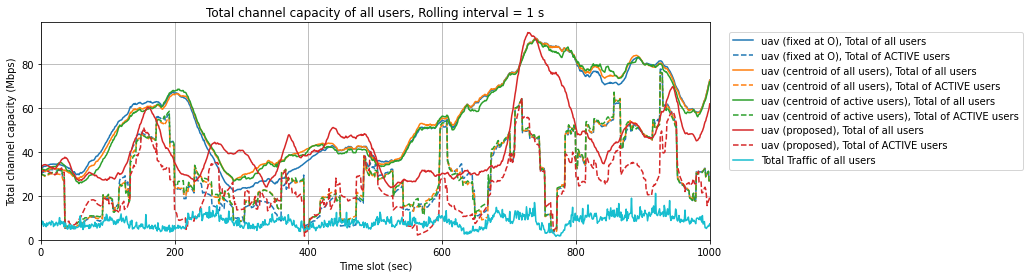

In [23]:
""" Total Channel Capacity """

plt.figure(figsize=(12,4))

for i, server in enumerate(servers):
    rolling_interval = 1
    kpi = export_moving_average(np.sum(server.channel_capacity_Mb, axis=0), 
                                rolling_intv=rolling_interval) 
    plt.plot(kpi, label=f'{server.name}, Total of all users', linestyle = '-', color=colors[i])      
    
    kpi2 = export_moving_average(np.sum(server.channel_capacity_Mb*server.active_state, axis=0),
                                rolling_intv=rolling_interval)
    plt.plot(kpi2, label=f'{server.name}, Total of ACTIVE users', linestyle = '--', color=colors[i])

traffic_incoming_avg = np.sum(arrival_traffic_Mb, axis=0)
plt.plot(traffic_incoming_avg, label='Total Traffic of all users', color='tab:cyan')

plt.legend(bbox_to_anchor=(1.02, 0.3), loc='lower left')
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim(bottom=0)

plt.xlabel('Time slot (sec)')
plt.ylabel('Total channel capacity (Mbps)')
plt.title(f'Total channel capacity of all users, Rolling interval = {rolling_interval} s')

plt.show()
# plt.savefig(f'channel capacity, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')



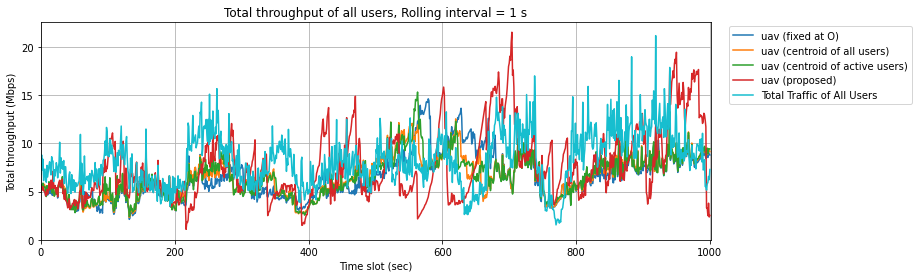

In [24]:
'''Total downlink throughtput of active users'''
plt.figure(figsize=(12,4))

for server in servers: 
    rolling_interval = 1
    
    # kpi = export_moving_average(np.sum(server.downlink_throughput_Mb*server.active_state, axis=0)/np.maximum(1,np.sum(server.active_state, axis=0)),
    #                             rolling_intv=rolling_interval)  # Average Throughput of Active Users, avoid deviding by 0  
    
    kpi = export_moving_average(np.sum(server.downlink_throughput_Mb, axis=0),
                                rolling_intv=rolling_interval)      # Total Throughput 
    
    sns.lineplot(kpi, label=server.name)            
    
# plt.plot(np.sum(arrival_traffic_Mb, axis=0) / np.sum(traffic_state, axis=0), 
#          label='AVG Arrival Traffic of ON users', color='tab:cyan')   # Average Throughput of Active Users 

# Total Arrival Traffic of All Users
sns.lineplot(np.sum(arrival_traffic_Mb, axis=0), label='Total Traffic of All Users', color='tab:cyan')    

plt.legend(bbox_to_anchor=(1.02, 0.6), loc='lower left')
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim(bottom=0)

plt.xlabel('Time slot (sec)')
plt.ylabel('Total throughput (Mbps)')
plt.title(f'Total throughput of all users, Rolling interval = {rolling_interval} s')

plt.show()
# plt.savefig(f'throughput of active users, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

##### Queue Length

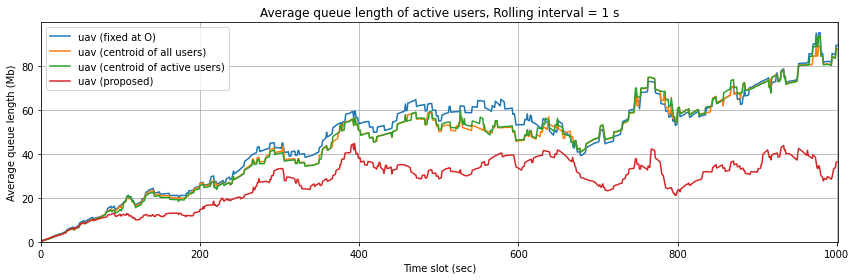

In [28]:
'''Average queue of one user'''
plt.figure(figsize=(12,4))

for server in servers: 
    rolling_interval = 1
    kpi = export_moving_average(np.sum(server.queue_length_Mb, axis=0)/np.sum(server.active_state, axis=0),
                                rolling_intv=rolling_interval)          # Average Queue Length 
    
    # kpi = export_moving_average(np.sum(server.queue_length_Mb, axis=0),
                                # rolling_intv=rolling_interval)        # Total Queue Length 
                                
    ax = sns.lineplot(kpi, label=server.name)

plt.legend()
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim(bottom=0)

plt.xlabel('Time slot (sec)')
plt.ylabel('Average queue length (Mb)')
plt.title(f'Average queue length of active users, Rolling interval = {rolling_interval} s')

plt.tight_layout()

plt.show()
# plt.savefig(f'queue size, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

##### QoE Score (MOS)
Note: if a user is inactive, their MOS equals `np.nan` and will be counted.

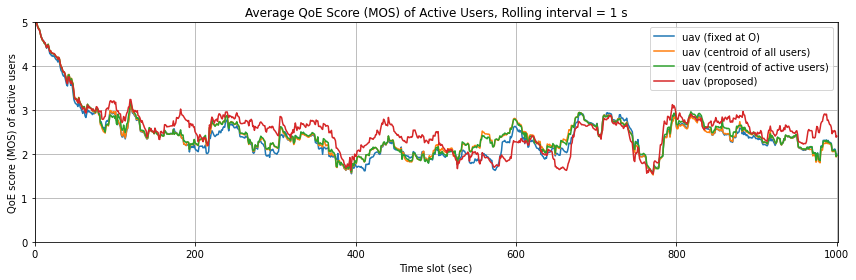

In [26]:
''' Plot the average MOS of users over time '''
plt.figure(figsize=(12,4))

for server in servers: 
    rolling_interval = 1
    kpi = export_moving_average(np.nanmean(server.mos, axis=0), rolling_intv=rolling_interval)   
    ax = sns.lineplot(kpi, label=server.name)

    # df = pd.DataFrame(server.mos)  
    # ax.fill_between(x = np.arange(0,n_slots), 
    #                 y1 = df.transpose().apply(np.min, axis=1).values,
    #                 y2 = df.transpose().apply(np.max, axis=1).values, 
    #                 alpha=0.5)
    

plt.legend()
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim([1,5])
plt.yticks(np.arange(0,6))

plt.xlabel('Time slot (sec)')
plt.ylabel('QoE score (MOS) of active users')
plt.title(f'Average QoE Score (MOS) of Active Users, Rolling interval = {rolling_interval} s')
plt.tight_layout()

plt.show()
# plt.savefig(f'queue size, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

In [27]:
# df = pd.DataFrame(server.mos)  
# print(df.transpose().head(5))
# x = df.transpose().apply(np.min, axis=1).values
# print(x.shape)


##### Other plots

In [ ]:
""" Plot radius distance """
# for user_idx, user in enumerate(users): 
#     radius_distance = np.sqrt(user.x**2 + user.y**2)       # shape = (n_slots,)
#     plt.plot(radius_distance, label=f'user[{user_idx}]')
# plt.grid(True)
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Radius distance (m)')
# plt.legend()
# plt.show()


""" Plot propagation distance """
# for user_idx, user in enumerate(users): 
#     propagation_distance = np.sqrt(user.x**2 + user.y**2 + uav_altitude**2)       # shape = (n_slots,)
#     plt.plot(propagation_distance, label=f'user[{user_idx}]')
# plt.grid(True)
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Communication distance (m), UAV (fixed)')
# plt.legend()
# plt.show()


"""Plot received signal strength"""
# for user_idx, user in enumerate(users): 
#     signal_strength = pTx_downlink * uav_fixed.chgains_downlink[user_idx,:]
#     plt.plot( to_dBm(signal_strength), label=f'user[{user_idx}]' )
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Signal strength (dBm)')
# plt.legend()
# plt.grid(True)
# plt.show()


""" Plot SNR (dB) """
# for user_idx, user in enumerate(users):
#     # SNR = pTx_downlink * uav_centroid.chgains_downlink[user_idx,:] / noise_pw_total
#     SNR = pTx_downlink * uav_fixed.chgains_downlink[user_idx,:] / noise_pw_total
#     plt.plot(to_dB(SNR), label=f'user[{user_idx}]')
# plt.xlabel('Time slot (sec)')
# plt.ylabel('SNR (dB)')
# plt.legend()
# plt.grid(True)
# plt.show()


""" Plot SNR (dB) for one user between two cases """
# SNR = pTx_downlink * uav_centroid.chgains_downlink[user_idx,:] / noise_pw_total
# user_idx = 0
# SNR_fixed = pTx_downlink * uav_fixed.chgains_downlink[user_idx,:] / noise_pw_total
# SNR_centroid = pTx_downlink * uav_centroid.chgains_downlink[user_idx,:] / noise_pw_total
# plt.plot(to_dB(SNR_fixed), label=f'user[{user_idx}], UAV fixed')
# plt.plot(to_dB(SNR_centroid), label=f'user[{user_idx}], UAV (centroid)')
# plt.xlabel('Time slot (sec)')
# plt.ylabel('SNR (dB)')
# plt.legend()
# plt.grid(True)
# plt.show()


""" UAV (fixed) : Channel capacity for each user """
# for user_idx, user in enumerate(users): 
#     plt.plot(uav_fixed.channel_capacity_Mb[user_idx,:], label=f'user[{user_idx}]')
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Channel capacity of each users (Mb/slot), UAV (fixed)')
# plt.legend()
# plt.grid(True)
# plt.show()

### Training history

In [ ]:
'''Plot training history'''
plt.figure()

train_loss_hist = uav_controller.train_loss_history
time_axis = np.arange(stop=len(train_loss_hist))*uav_controller.training_interval
plt.plot(time_axis, train_loss_hist, label='train loss')

val_loss_hist = uav_controller.val_loss_history
plt.plot(time_axis, val_loss_hist, label='validation loss')

# test_loss_history = export_moving_average(uav_controller.test_loss_history, rolling_intv=100)
# plt.plot(test_loss_history, label='test loss')

plt.legend()
plt.grid(True)

# y_min, y_max, y_step = 0.08, 0.41, 0.05
# x_min, x_max = -100, 5100 
plt.xlim(0, n_slots)
# plt.ylim(y_min, y_max)
# plt.yticks(np.arange(0.1, 0.41, step=y_step))

plt.xlabel('Time slot (second)')
plt.ylabel('Loss')

# plt.show()
plt.savefig('train_history', dpi=300, bbox_inches='tight')


### Illustrate the problem at a specific time

In [ ]:
t = 2612
marker_sz = 10
xy_add = 7
mdir_uav_proposed = 7       # in # of time slots 
mdir_user = 70

for t in range(0, 500, 5):
    
    '''Calcualte downlink throughput'''
    alpha = np.ones(shape=(n_users)) * 1/n_users        # equal bandwidth allocation
    qlen_prev_Mb = uav_proposed.queue_length_Mb[:,t-1] if t > 0 else 0
    arrival_Mb = uav_proposed.arrival_traffic_Mb[:,t]

    chgains_downlink = np.zeros(shape=(n_users,))
    channel_capacity_Mb = np.zeros(shape=(n_users,))
    qlen_next_Mb = np.zeros(shape=(n_users,))
    throughput_dict = {}


    for server in servers: 
        downlink_throughput_Mb = np.zeros(shape=(n_users,))
        for i, user in enumerate(users): 
            chgains_downlink[i] = cal_channel_fading_gain(user.x[t], user.y[t], server.x[t], server.y[t], server.altitude)  
            channel_capacity_Mb[i] = cal_channel_capacity_Mb(chgains_downlink[i],  alpha=alpha[i])
            qlen_next_Mb[i] = update_queue_Mb(qlen_prev_Mb=qlen_prev_Mb[i], 
                                                arrival_Mb=arrival_Mb[i],
                                                departure_Mb=channel_capacity_Mb[i])
            downlink_throughput_Mb[i] = cal_downlink_throughput_Mb(qlen_prev_Mb=qlen_prev_Mb[i], 
                                                                arrival_Mb=arrival_Mb[i],
                                                                channel_capacity_Mb=channel_capacity_Mb[i])  
        throughput_dict[server.name] = downlink_throughput_Mb 
        print(throughput_dict[server.name])


    '''Plot figures'''
    plt.figure(figsize=(5,5))    # figsize in inch 

    # Plot the boundary 
    radius = boundary  # in meter
    plt.plot(-radius, radius, 'sw', markersize=1)
    plt.plot(-radius, -radius, 'sw', markersize=1)
    plt.plot(radius, radius, 'sw', markersize=1)
    plt.plot(radius, -radius, 'sw', markersize=1)

    ### Plot users' location
    server = uav_proposed
    for user_idx, user in enumerate(users):
        plt.plot(user.x[t], user.y[t], linestyle='None', marker='+', color='k', markersize=marker_sz)
        plt.annotate(text=f'{server.queue_length_Mb[user_idx,t-1] + server.arrival_traffic_Mb[user_idx,t]:.1f}', 
                    xy=(user.x[t]+xy_add, user.y[t]+xy_add))
        # plt.arrow(x=user.x[t], y=user.y[t], dx=user.x[t+mdir_user]-user.x[t], dy=user.y[t+mdir_user]-user.y[t],
        #       color='k', head_width=15, head_length=15, overhang=1)
    plt.plot(user.x[t], user.y[t], linestyle='None', marker='+', color='k', markersize=marker_sz, label='mobile users')

    ### Plot the UAV located at O (fixed)
    server = uav_fixed 
    plt.plot(server.x[t], server.y[t], linestyle="None", marker='o', color='tab:blue', label=server.name, markersize=marker_sz)
    throughput_sum = np.sum(throughput_dict[server.name])
    plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+2, server.y[t]+xy_add+2), color='tab:blue')

    ### Plot the centroid of users' location 
    # plt.plot(x_centroid[t], y_centroid[t], '^b', label='centroid of all users')
    # print(x_centroid[t], y_centroid[t])

    ### Plot the UAV movement (following centroids of all users)
    server = uav_centroid
    plt.plot(server.x[t], server.y[t], linestyle='None', marker='s', color='tab:orange', label=server.name, markersize=marker_sz)
    throughput_sum = np.sum(throughput_dict[server.name])
    plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+5, server.y[t]+xy_add+5), color='tab:orange')
    # plt.arrow(x=server.x[t], y=server.y[t], dx=server.x[t+mdir_user]-server.x[t], dy=server.y[t+mdir_user]-server.y[t],
    #           color='b', head_width=15, head_length=15, overhang=1)

    ### Plot the UAV movement (proposed)
    server = uav_proposed
    plt.plot(server.x[t], server.y[t], linestyle='None', marker='^', color='tab:green', label=server.name, markersize=marker_sz)
    throughput_sum = np.sum(throughput_dict[server.name])
    plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+2, server.y[t]+xy_add+2), color='tab:green')
    # plt.arrow(x=server.x[t], y=server.y[t], dx=server.x[t+mdir_uav_proposed]-server.x[t], dy=server.y[t+mdir_uav_proposed]-server.y[t],
    #           color='r', head_width=15, head_length=15, overhang=1)

    plt.xlim(-270, 270)
    plt.ylim(-270, 270)
    plt.xticks(np.arange(-250, 251, step=100))
    plt.yticks(np.arange(-250, 251, step=100))
    plt.legend(loc='upper right')       # options: 'best', 'upper left', 'upper right', 'lower left', 'lower right'
    plt.grid(True)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.savefig(os.path.join(os.getcwd(), 'png', f"problem_illustration_t{t}.png"), bbox_inches='tight', dpi=600)


In [ ]:
'''Plot channel capacity of each user'''
# for user_id in range(n_users):
#     plt.plot(uav_fixed.channel_capacity_Mb[user_id,:], label='uav1 (fixed)')
#     plt.plot(uav_centroid.channel_capacity_Mb[user_id,:], label='uav2 (centroid)')
#     plt.xlabel('Time slot (sec)')
#     plt.ylabel(f'Channel capacity for user[{user_id}] (Mb/slot)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


### User heatmaps

In [ ]:
'''Test the UAV movement controller''' 
t = 400
x_raw = np.array([user.x[t] for user in users])
y_raw = np.array([user.y[t] for user in users])
x = x_raw + boundary
y = y_raw - boundary

server = uav_proposed

queue_Mb = server.queue_length_Mb[:,t]
traffic_Mb =  server.arrival_traffic_Mb[:,t]
ch_capacity_Mb = server.channel_capacity_Mb[:,t]

print(f'x_raw: {x_raw}')
print(f'y_raw: {y_raw}')
print(f'queue_Mb: {queue_Mb}')
print(f'traffic_Mb: {traffic_Mb}')
print(f'ch_capacity_Mb: {ch_capacity_Mb}')

heatmap = uav_controller.gen_heatmap(x_locations=x, y_locations=y, val=queue_Mb, norm_val=queue_norm_Mb)
heatmaps = uav_controller.preprocess_user_statistics(user_locations=(x,y), 
                                                user_statistics=(queue_Mb, traffic_Mb, ch_capacity_Mb),
                                                normalization_coeff=normalization_coeff)
print(f'heatmaps.shape={heatmaps.shape}')

for i in range(heatmaps.shape[-1]):
    hm = sns.heatmap(data=heatmaps[:,:,i], square=True, annot = False, xticklabels=True)
    plt.title(f't={t}, heatmap channel={i}')
    plt.show() 


print(heatmaps[2])

# Export data

DNN model summary

In [ ]:
uav_controller.model.summary()

from keras.utils.vis_utils import plot_model
plot_model(uav_controller.model, to_file='dnn_model.png', 
           show_shapes=True, 
           show_layer_names=False, 
           rankdir = 'TB',      # 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
           expand_nested = False,
           dpi=600)

Export KPI data to xlsx files

In [ ]:
import pandas as pd 

queue_dict = {}
throughput_dict = {}
throughput_avg_alltime_dict = {}

for server in servers:
    queue_dict[server.name] = np.mean(server.queue_length_Mb, axis=0)
    throughput_dict[server.name] = np.sum(server.downlink_throughput_Mb, axis=0)/np.maximum(1, np.sum(server.active_state, axis=0))  # avoid devided by 0
    throughput_avg_alltime_dict[server.name] = np.array([np.sum(server.downlink_throughput_Mb)/np.sum(server.active_state)])

kpis = {'queue_Mb': queue_dict,                             # queue length over time 
        'throughput_Mb': throughput_dict,                   # average throughput of active users over time 
        'throughput_avg_alltime_Mb': throughput_avg_alltime_dict,       # average throughput of all time 
        'train_loss': uav_controller.train_loss_history,     
        'validation_loss': uav_controller.val_loss_history  
        }

for kpi_name, kpi_dict in kpis.items(): 
    filename_xlsx = f'{kpi_name}.xlsx'
    dataframe_lambda = pd.DataFrame(kpi_dict) 
    dataframe_lambda.to_excel( os.path.join( os.getcwd(), 'xlsx', filename_xlsx ) )
print('Exported KPI data to Excel files')
print('Path="{path}"'.format(path={os.path.join(os.getcwd(), 'xlsx')}))


Export class objects to pickle files

In [ ]:
import pickle  

folder_path = os.path.join( os.getcwd(), 'pickle' )

for server in servers: 
    filename = f'{server.name}.pickle'
    save_data(server, filepath=os.path.join(folder_path, filename))
print('Exported all uav objects to pickle files')

for user in users:
    filename = f'{user.name}.pickle'
    save_data(user, filepath=os.path.join(folder_path, filename))
print('Exported all user objects to pickle files')


Load class objects from pickle files

In [ ]:
from utils import * 

server_loaded = []
users_loaded = []

server_names = ['uav (fixed at O)', 'uav (centroid of all users)', 'uav (proposed)']
user_names = ['user[0]', 'user[1]', 'user[2]', 'user[3]', 'user[4]']

folder_path = os.path.join( os.getcwd(), 'pickle' )
for name in server_names: 
    filename = f'{name}.pickle'
    server_loaded.append(load_data(os.path.join(folder_path, filename)))
    
for name in user_names:
    filename = f'{name}.pickle'
    users_loaded.append(load_data(os.path.join(folder_path, filename)))
print('Loaded user and user objects from pickle files')


In [ ]:
for server in server_loaded:
    print(server.name)
for user in users_loaded: 
    print(user.name)